In [1]:
import sys
sys.path.append('../src')

from loader import train_dev_test, imread
import matplotlib.pyplot as plt
from preprocessing import (str2coords, 
                           coords2str,
                           rotate,
                           coords_to_2d,
                           get_img_coords,
                           preprocess_image,
                           get_mask_and_regr)
from visualizing import imshow_train, show_img_mask, visualize
import numpy as np
from postprocessing import (convert_3d_to_2d,
                            clear_duplicates,
                            extract_coords)
from modeling import MyUNet, criterion, criter_objective, car_detector
import torch
from torch import optim

In [2]:
train, test, train_dataset, dev_dataset, test_dataset=train_dev_test(PATH = '../data/pku-autonomous-driving/')

num of cars outside image bounds: 998 out of all 49684  cars in train


In [3]:
PATH = '../data/pku-autonomous-driving/'
img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

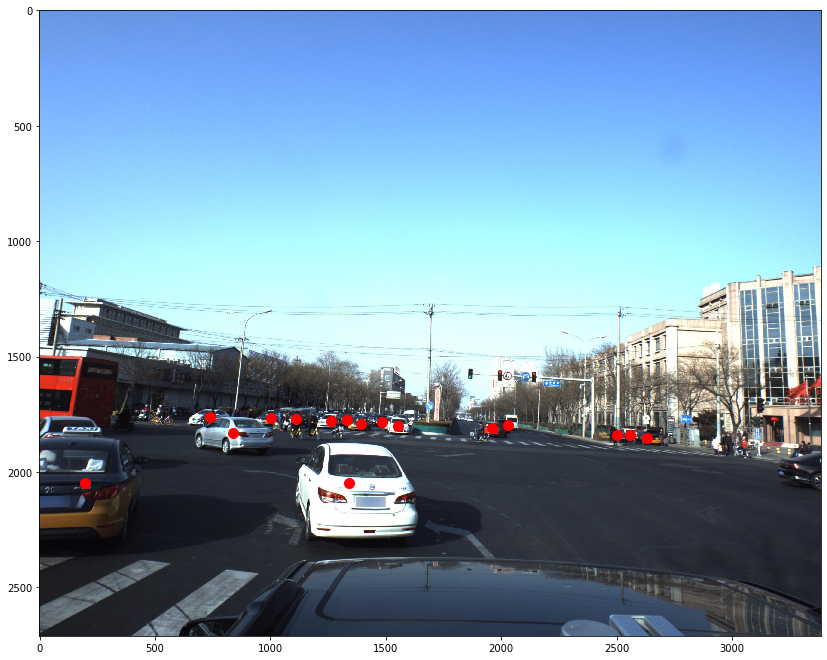

In [4]:
plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
xs, ys = get_img_coords(train['PredictionString'][2217])
plt.scatter(xs, ys, color='red', s=100);

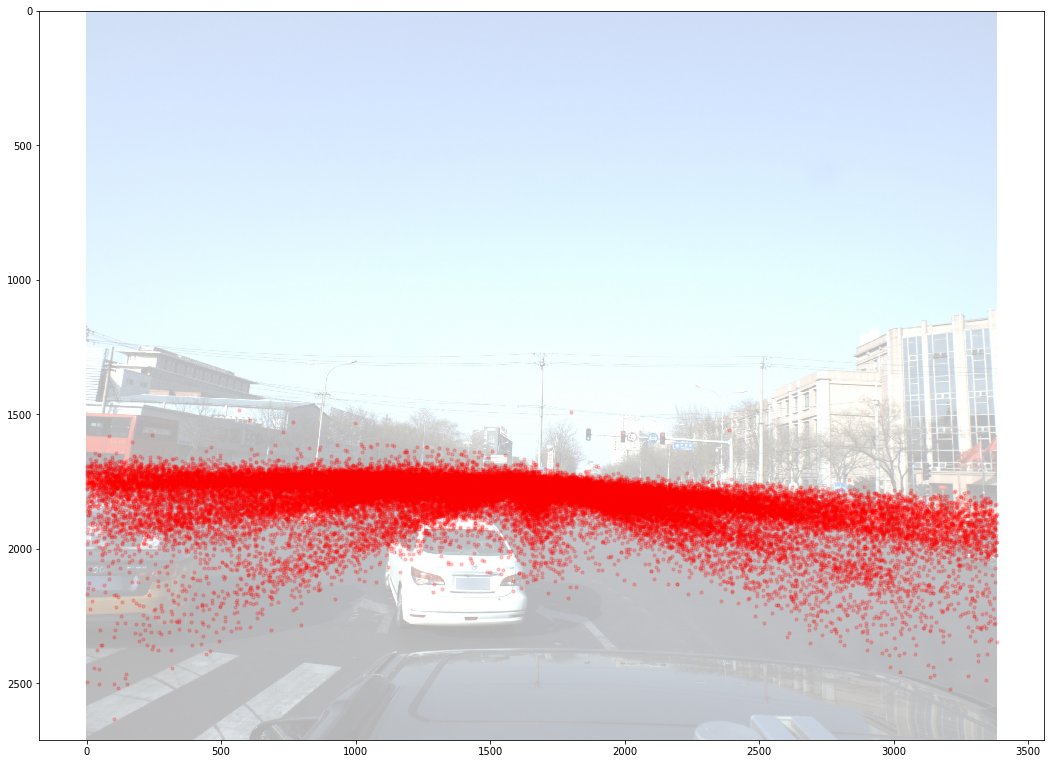

In [5]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

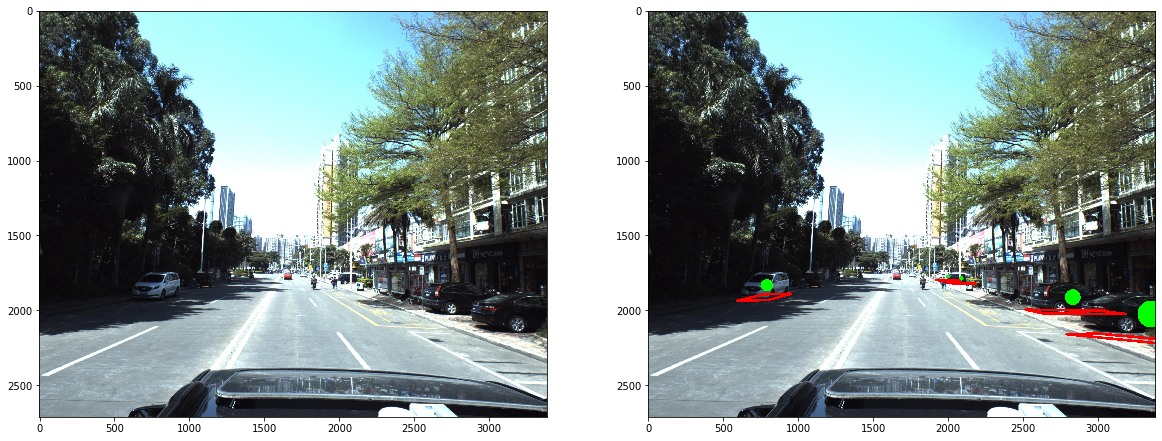

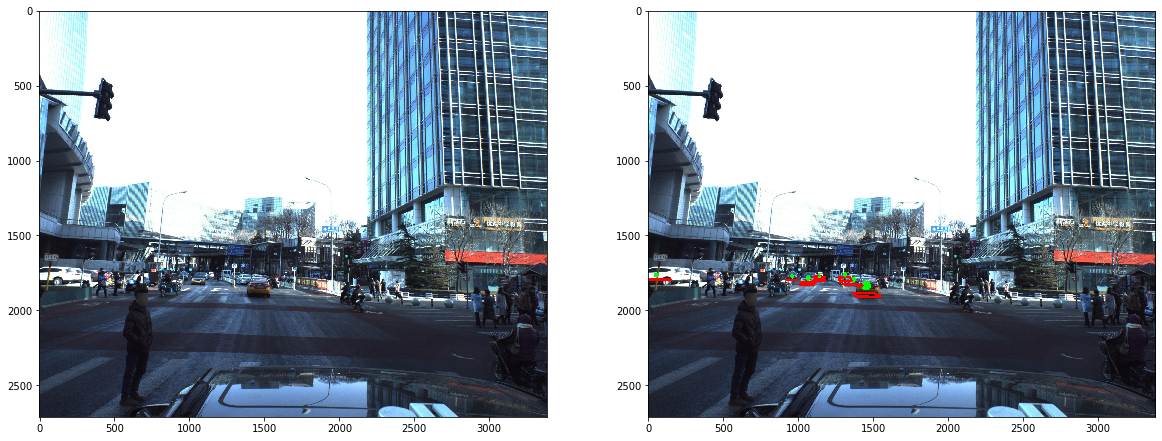

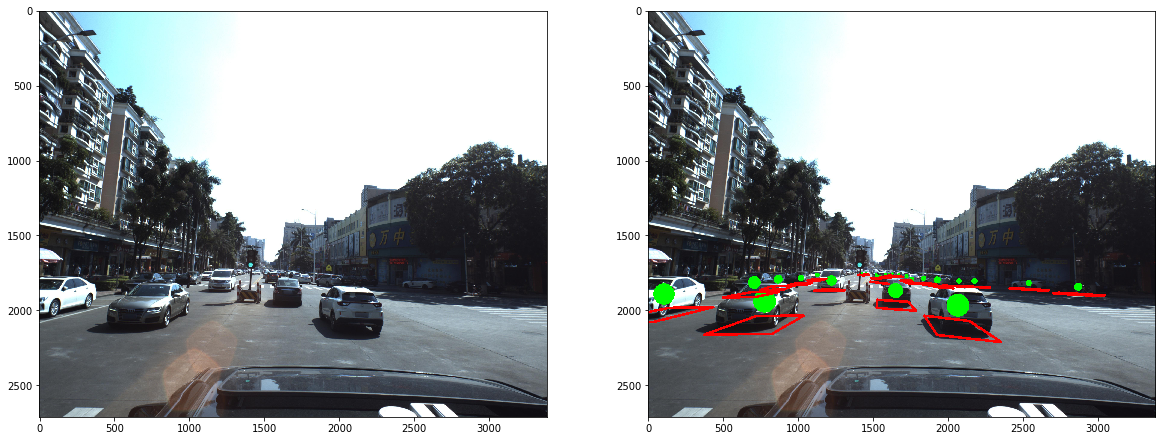

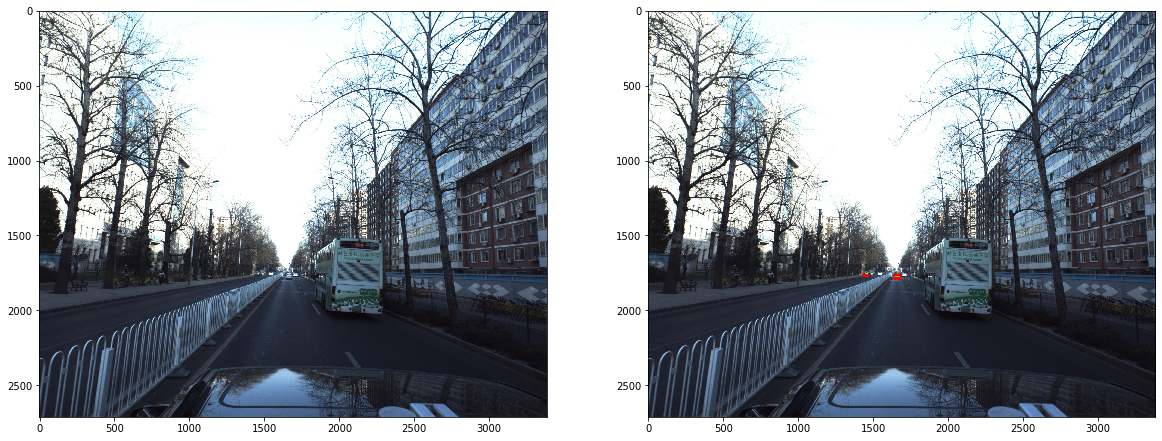

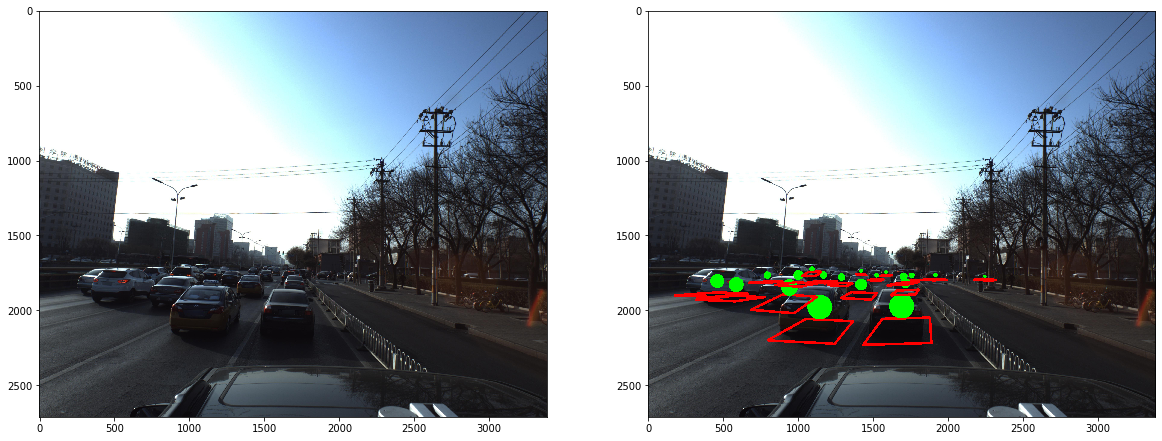

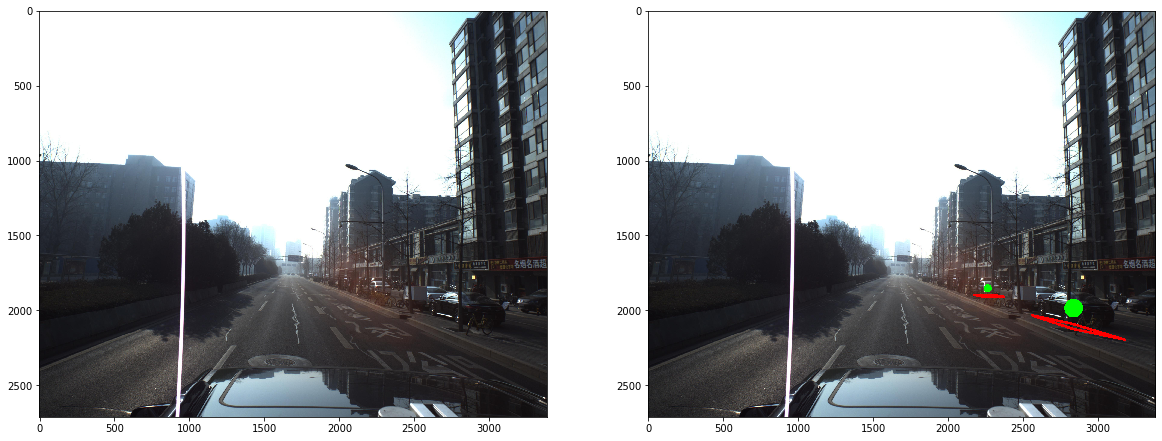

In [6]:
n_rows = 6

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()

In [7]:
img0 = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
img = preprocess_image(img0)

mask, regr, mask_gaus = get_mask_and_regr(img0, train['PredictionString'][0])

img.shape (500, 1600, 3) std: 0.29817325
mask.shape (62, 200) std: 0.020076435
regr.shape (62, 200, 7) std: 0.008489681


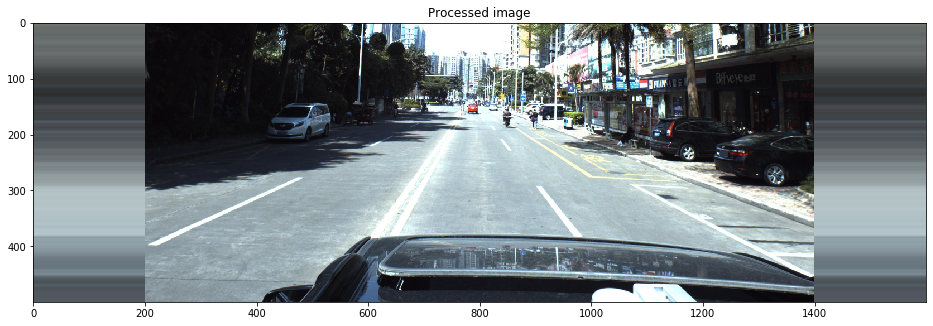

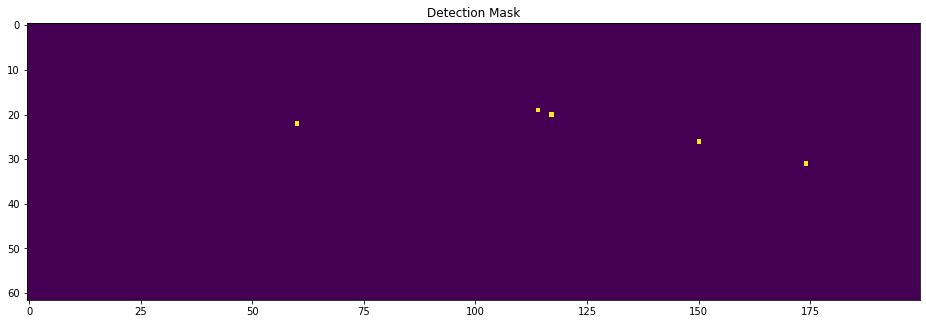

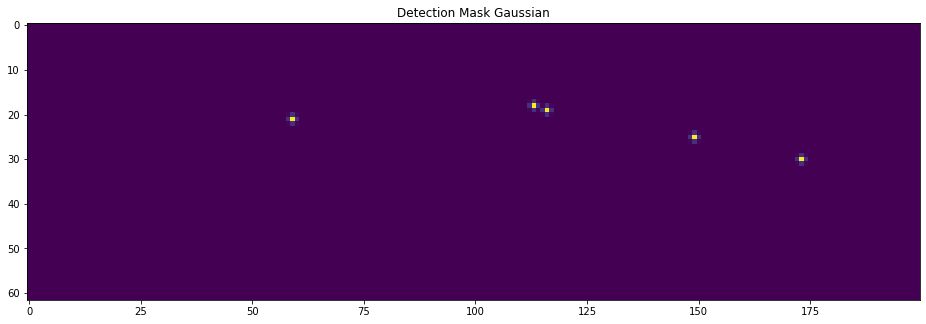

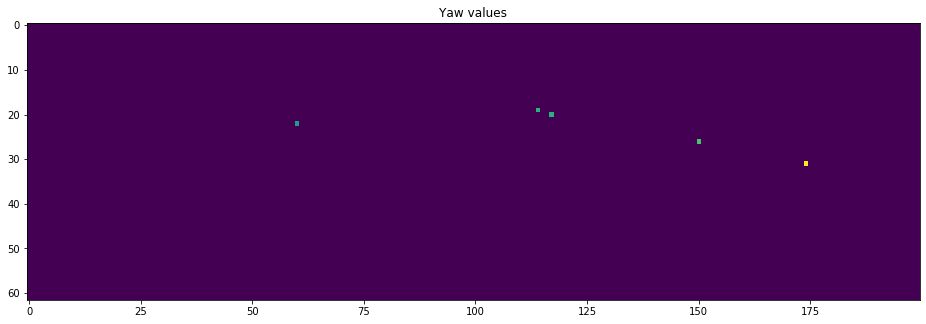

In [8]:
print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask Gaussian')
plt.imshow(mask_gaus)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

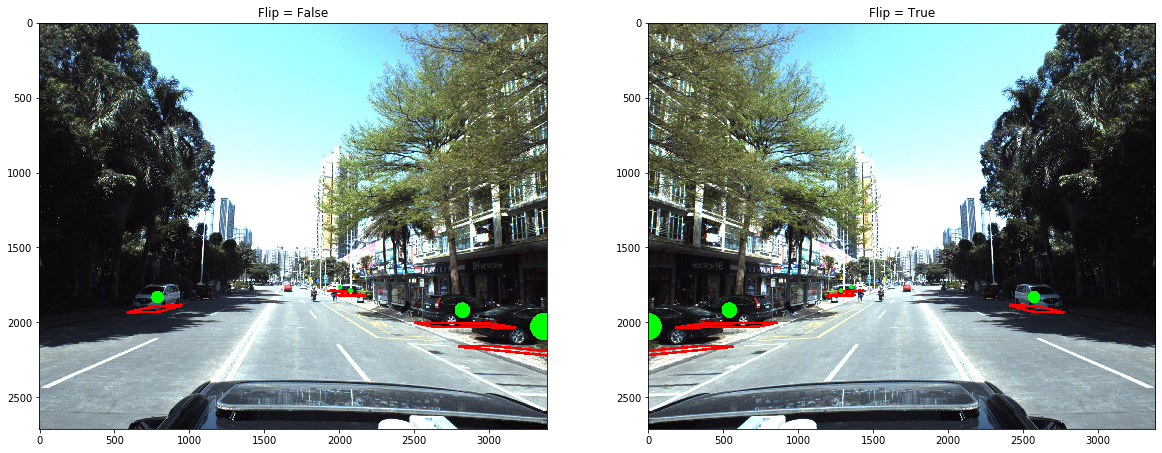

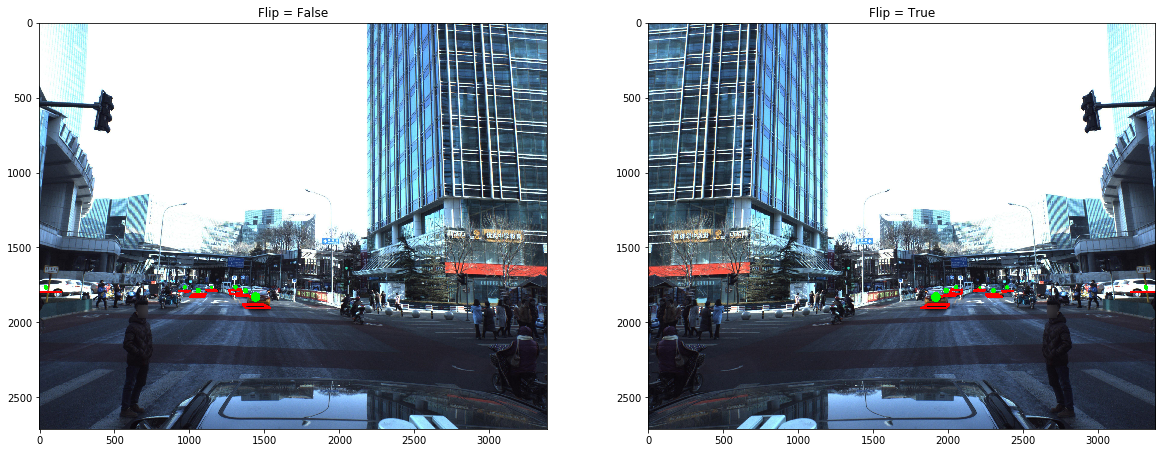

In [9]:
IMG_WIDTH = 1600
IMG_HEIGHT = IMG_WIDTH // 16 * 5
MODEL_SCALE = 8

for idx in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    
    for ax_i in range(2):
        img0 = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
        if ax_i == 1:
            img0 = img0[:,::-1]
        img = preprocess_image(img0, img_w=IMG_WIDTH, img_h=IMG_HEIGHT, flip=(ax_i==1))
        mask, regr, mask_gaus = get_mask_and_regr(img0, train['PredictionString'][idx], flip=(ax_i==1))
        regr = np.rollaxis(regr, 2, 0)
        coords = extract_coords(np.concatenate([mask[None], regr], 0), 0, ax_i==1)
        
        axes[ax_i].set_title('Flip = {}'.format(ax_i==1))
        axes[ax_i].imshow(visualize(img0, coords))
    plt.show()

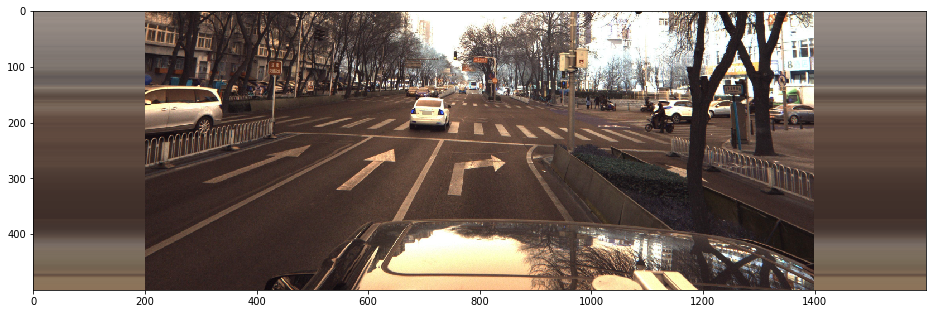

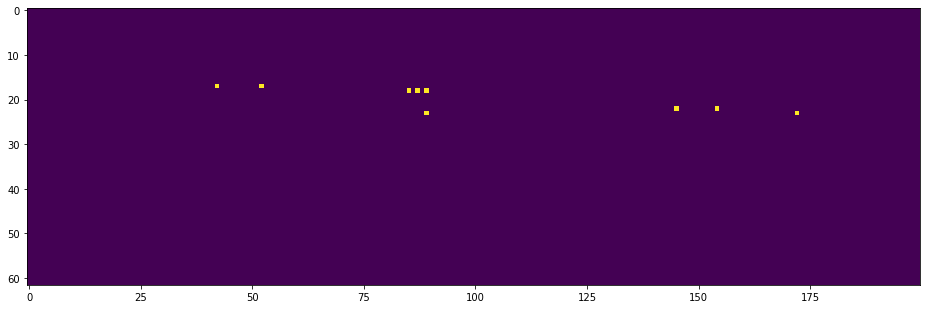

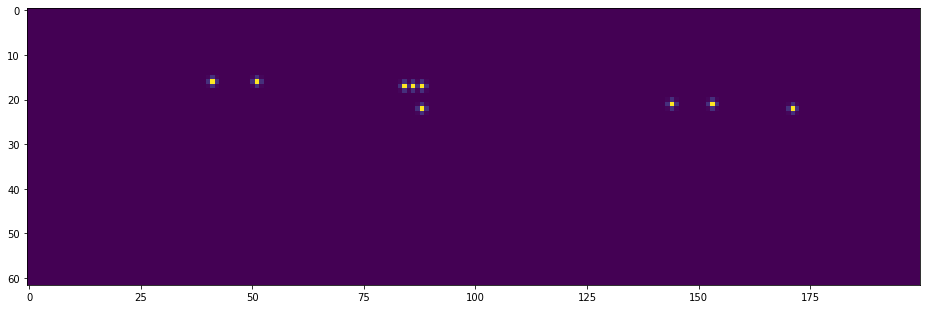

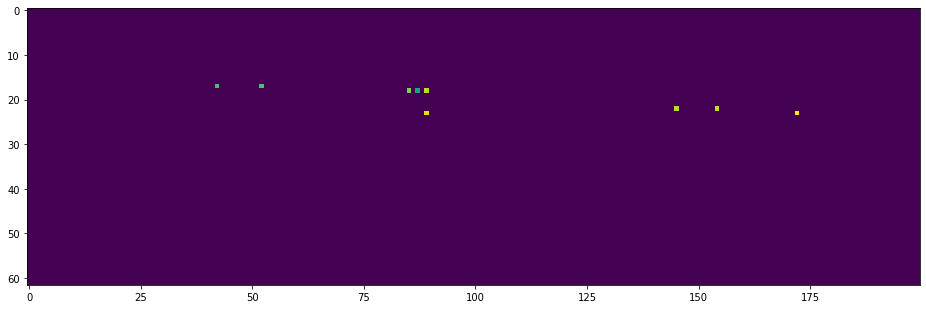

In [10]:
img, mask, regr, mask_gaus, drop_mask = train_dataset[20]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img.data.cpu().numpy(), 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask_gaus)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [37]:
n_epochs = 12
device = torch.device("cuda")
model = MyUNet(8,batch_size=4).to(device)
car_detector = car_detector(
                 model, 
                 train_dataset,
                 dev_dataset,
                 device = torch.device("cuda"), 
                 optimizer=optim.AdamW,
                 lr=0.001,
                 n_epoch = 1, 
                 batch_size = 4,
                 w_mask = 0.1,
                 history=None
                )

Loaded pretrained weights for efficientnet-b0


TypeError: 'car_detector' object is not callable

In [24]:
for batch_idx, (img_batch, mask_batch, regr_batch, mask_gaus_batch, _) in enumerate(car_detector.train_loader):
    if batch_idx>0:
        break

In [14]:
from modeling import get_mesh

In [28]:
img_batch = img_batch.to(device)
mask_batch = mask_batch.to(device)
regr_batch = regr_batch.to(device)
mask_gaus_batch = mask_gaus_batch.to(device)
output = car_detector.model(img_batch)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 8 and 4 in dimension 0 at /opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/THC/generic/THCTensorMath.cu:71

In [30]:
mesh1 = get_mesh(4, img_batch.shape[2], img_batch.shape[3])

In [32]:
mesh1.shape

torch.Size([4, 2, 500, 1600])

In [36]:
img_batch.shape

torch.Size([4, 3, 500, 1600])

In [35]:
torch.cat([img_batch, mesh1], 1)

tensor([[[[7.6078e-01, 7.6078e-01, 7.6078e-01,  ..., 7.6078e-01,
           7.6078e-01, 7.6078e-01],
          [7.6471e-01, 7.6471e-01, 7.6471e-01,  ..., 7.6471e-01,
           7.6471e-01, 7.6471e-01],
          [7.7647e-01, 7.7647e-01, 7.7647e-01,  ..., 7.7647e-01,
           7.7647e-01, 7.7647e-01],
          ...,
          [3.2941e-01, 3.2941e-01, 3.2941e-01,  ..., 3.2941e-01,
           3.2941e-01, 3.2941e-01],
          [3.2941e-01, 3.2941e-01, 3.2941e-01,  ..., 3.2941e-01,
           3.2941e-01, 3.2941e-01],
          [3.2941e-01, 3.2941e-01, 3.2941e-01,  ..., 3.2941e-01,
           3.2941e-01, 3.2941e-01]],

         [[7.4510e-01, 7.4510e-01, 7.4510e-01,  ..., 7.4510e-01,
           7.4510e-01, 7.4510e-01],
          [7.4902e-01, 7.4902e-01, 7.4902e-01,  ..., 7.4902e-01,
           7.4902e-01, 7.4902e-01],
          [7.6078e-01, 7.6078e-01, 7.6078e-01,  ..., 7.6078e-01,
           7.6078e-01, 7.6078e-01],
          ...,
          [2.6275e-01, 2.6275e-01, 2.6275e-01,  ..., 2.6275